# **Super Mario with Deep Q-Learning**
![Super Mario GIF](https://i.pinimg.com/originals/63/dd/d7/63ddd7f601b6c9961e83fc5f45bd67f5.gif)

**This Notebook where we explore how to train an AI agent to play Super Mario using Deep Q-Learning (DQL). 
DQL is a powerful reinforcement learning technique that combines Q-learning with deep neural networks, allowing the agent to learn how to play complex games from raw pixel data.**


In [1]:
# Installation of Required Packages
#--------------------------------------------------
# !pip install gym-super-mario-bros==7.4.0
# !pip install gym==0.26.2
# !pip install nes-py==8.2.1
# !pip install tensordict
# !pip install torchrl
# !pip install gym[other]

In [1]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
from nes_py.wrappers import JoypadSpace
from tensordict import TensorDict
import gym_super_mario_bros
import plotly.express as px
from torch import nn
import numpy as np
import torch
import gym
import time

## Environment Preprocess
The preprocess of the inviroment involves applying several wrappers to preprocess the game frames for our neural network.

Wrappers help in:
- **Frame Skipping**: Reducing the number of frames the agent needs to process.
- **Resizing**: Making the frame dimensions smaller for faster processing.
- **Grayscale Conversion**: Simplifying the input by reducing it to a single color channel.
- **Normalization**: Scaling pixel values to [0, 1] range.
- **Frame Stacking**: Providing a sequence of frames to the agent to give it a sense of motion.


In [2]:
class SkipperFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip                            

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, trunc, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunc, info


def apply_wrappers(env):
    env = SkipperFrame(env, skip=4)                            
    env = ResizeObservation(env, shape=84)                     
    env = GrayScaleObservation(env)                            
    env = TransformObservation(env, f=lambda x: x / 255.)      
    env = FrameStack(env, num_stack=4, lz4_compress=True)     

    return env

## Convolutional Neural Network (CNN) Model
Our agent uses a CNN to process frames from the game and extract important features for decision-making.
The CNN consists of convolutional layers followed by fully connected layers to predict the best action.

<img src="https://brandinho.github.io/images/mario-model-architecture.png" alt="CNN Architecture" width="650" style="display: block; margin: 0 auto"/>


In [8]:
class CNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze =False):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.model = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
        if freeze:
                self._freeze()
                
                
        if torch.cuda.is_available():
            self.device = 'cuda'
            print("Using CUDA device:", torch.cuda.get_device_name(0))
        else:
            self.device = 'cpu'
            print("CUDA is not available")
    
        self.to(self.device)


    def _get_conv_out(self, shape):
        """
        Helper function to calculate the size of the output from the convolutional layers.
        """
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        return self.model(x)
    
    def _freeze(self):
        """
        Freeze the network's parameters to prevent them from being updated.
        """
        for param in self.parameters():
            param.requires_grad = False

## DQN Agent
The DQN agent interacts with the environment to learn optimal actions using a neural network.
The agent leverages experience replay and periodically updates a target network to stabilize learning.

<img src="https://blog.damavis.com/wp-content/uploads/2022/04/image2-2.png" alt="DQN" width="800"/>


In [5]:
class Agent:
    def __init__(self, input_dims, num_actions, lr=0.00025, gamma=0.9, epsilon=1.0, 
                 eps_decay=0.999975, eps_min=0.1, replay_buffer_capacity=80_000, 
                 batch_size=32, sync_network_rate=300):
        
        self.num_actions = num_actions
        self.learn_step_counter = 0

        # Hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.sync_network_rate = sync_network_rate

        # Networks
        self.model = CNN(input_dims, num_actions)
        self.target_model = CNN(input_dims, num_actions, freeze=True)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        # self.loss = torch.nn.SmoothL1Loss() # Feel free to try this loss function instead!

        # Replay buffer
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def chose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:

            state = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(self.model.device)
            action = self.model(state).argmax().item()
        return action
    
    def decay_epsilon(self):
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)

    
    def store_in_memory(self, state, action, reward, next_state, done):
        self.replay_buffer.add(TensorDict({
                                            "state": torch.tensor(np.array(state), dtype=torch.float32), 
                                            "action": torch.tensor(action),
                                            "reward": torch.tensor(reward), 
                                            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32), 
                                            "done": torch.tensor(done)
                                          }, batch_size=[]))
        
    def sync_model(self):
        if (self.learn_step_counter % self.sync_network_rate == 0) and (self.learn_step_counter > 0):
            self.target_model.load_state_dict(self.model.state_dict())
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.target_model.load_state_dict(torch.load(path))
        
    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
       
        self.sync_model()
        self.optimizer.zero_grad()
        
        samples = self.replay_buffer.sample(self.batch_size).to(self.model.device)

        keys = ["state", "action", "reward", "next_state", "done"]
        
        states, actions, rewards, next_states, dones = [samples[key] for key in keys]
        
        predict_q_values = self.model(states)
        predict_q_values = predict_q_values[np.arange(self.batch_size), actions.squeeze()]
        
        target_q_values = self.target_model(next_states).max(dim=1)[0]
        
        target_q_values = rewards.squeeze() + self.gamma * target_q_values * (1 - dones.float())
        
        loss = self.loss(predict_q_values, target_q_values)
        
        loss.backward()
        self.optimizer.step()
        
        self.learn_step_counter += 1
        self.decay_epsilon()
        
        
        return loss.item()

## Setting up the enviroment

In [ ]:
ENV_NAME = "SuperMarioBros-1-1-v0"
SIMPLE_MOVEMENT = [["right"], ["right", "A"]]

env = gym_super_mario_bros.make(ENV_NAME,render_mode="rgb_array", apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = apply_wrappers(env)

IMG_SIZE = env.observation_space.shape

agent = Agent(input_dims=IMG_SIZE, num_actions=len(SIMPLE_MOVEMENT), batch_size=32)

## Training Mario 🎮

In [7]:
import logging
from collections import deque
import numpy as np
from rich.logging import RichHandler
from rich.progress import track

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    handlers=[RichHandler(), logging.FileHandler("training_log.txt", mode="w")],
)

logger = logging.getLogger("training_logger")

def train(agent, env, num_episodes=1000, ckpt_save_interval=100, log=True):
    history = {
        "rewards": [],
        "loss": [],
        "epsilon": [],
        "buffer": []
    }
    
    rewards_window = deque(maxlen=100)
    loss_window = deque(maxlen=100)
    
    def save_checkpoint(episode):
        agent.save_model(f"model_mario_{episode}.pt")
        if verbose:
            logger.info(f"Checkpoint saved at episode {episode}")

    for episode in track(range(1, num_episodes + 1), 'Training Mario 👾...'):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        total_loss = 0.0

        while not done:
            action = agent.chose_action(state)
            next_state, reward, done, trunc, info = env.step(action)

            # Store transition in memory
            agent.store_in_memory(state, action, reward, next_state, done or trunc)

            # Perform learning step
            loss = agent.learn()
            state = next_state

            # Accumulate rewards and losses
            total_reward += reward
            if loss is not None:
                total_loss += loss

        # Append the reward of the current episode to the window
        rewards_window.append(total_reward)
        loss_window.append(total_loss)
        
        # Calculate the mean reward of the last 100 episodes
        mean_reward_100 = np.mean(rewards_window)
        mean_loss_100 = np.mean(loss_window)
        history["rewards"].append(mean_reward_100)
        history["loss"].append(mean_loss_100)
        history["epsilon"].append(agent.epsilon)
        history["buffer"].append(len(agent.replay_buffer))

        # Log details of the episode
        if log:
            logger.info(
                f"Episode {episode} | Total Reward: {total_reward:.2f} | "
                f"Mean Reward (100): {mean_reward_100:.2f} | "
                f"Total Loss: {total_loss:.2f} | "
                f"Epsilon: {agent.epsilon:.2f} | "
                f"Replay Buffer Size: {len(agent.replay_buffer)}"
            )

        # Save checkpoint at specified intervals
        if episode % ckpt_save_interval == 0:
            save_checkpoint(episode)

    return history

In [ ]:
history = train(agent, env, num_episodes=7000, ckpt_save_interval=500, log=True)

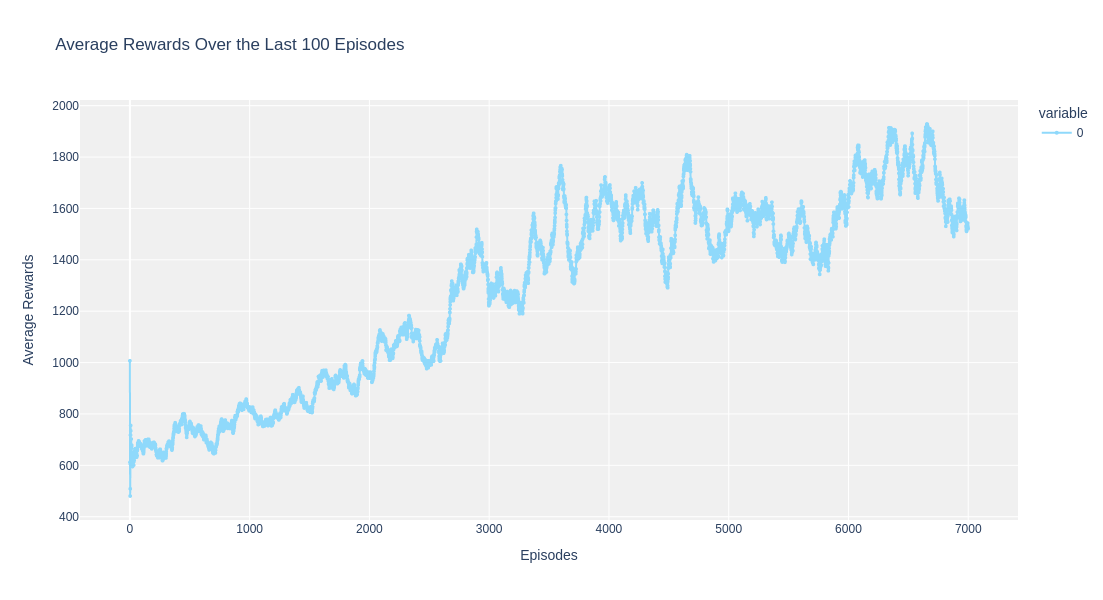

In [52]:
import plotly.express as px
import plotly.graph_objects as go

# Create a line plot for average rewards
fig = px.line(
    history["rewards"],
    labels={'value': 'Average Rewards', 'index': 'Episodes'},
    title='Average Rewards Over the Last 100 Episodes',
)

# Update layout for improved readability and style
fig.update_layout(
    width=1000,
    height=600,
    xaxis=dict(
        title="Episodes",
        showgrid=True,
        zeroline=True,
    ),
    yaxis=dict(
        title="Average Rewards",
        showgrid=True,
        zeroline=True,
    ),
    title="Average Rewards Over the Last 100 Episodes",
    plot_bgcolor='rgba(240,240,240,0.95)',
)

# Optionally customize the line style
fig.update_traces(
    line=dict(color='#8fd9fb', width=2),
    mode='lines+markers',
    marker=dict(size=4, symbol='circle')
)

# Show the plot
fig.show()


## Test the Agent

In [53]:
import time 

def test(model='model_mario_1000.pt',num_epsisodes=10, epsilon=0.1):
    
    mario = Agent(input_dims=IMG_SIZE, num_actions=len(SIMPLE_MOVEMENT), epsilon=epsilon)
    mario.load_model(model)
    
    
    ENV_NAME = "SuperMarioBros-1-1-v0"
    env = gym_super_mario_bros.make(ENV_NAME,render_mode="human", apply_api_compatibility=True)
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = apply_wrappers(env)
    done = False 

    for _ in range(num_epsisodes):
        state,_ = env.reset()
        while not done:
            env.render()
            action = mario.chose_action(state)
            next_state, reward, done, trunc, info = env.step(action)
            state = next_state

            time.sleep(0.01)
        done = False


    env.close()

In [55]:
%%capture

test('model_mario_6500.pt',num_epsisodes=1, epsilon=0.02)